In [ ]:
# Install Modules from internet
!pip install efficientnet
!pip install iterative-stratification

In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
from imgaug import augmenters as iaa

from math import ceil, floor, log
import cv2

import tensorflow as tf
import keras

import sys

import efficientnet.keras as efn 
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.model_selection import ShuffleSplit

test_images_dir = 'E:/rsna-intracranial-hemorrhage-detection/stage_2_test_images/'
train_images_dir = 'E:/rsna-intracranial-hemorrhage-detection/stage_2_train_images/'


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


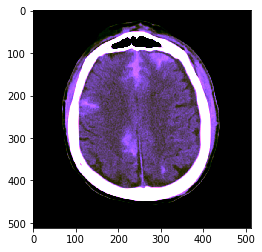

In [2]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def thresholding(dcm, low, high):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)

    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img[np.where(img<low)] = 0.0
    img[np.where(img>high)] =0.0
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 30, 30)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - 15) / 30
    
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# Sanity Check
# Example dicoms: ID_2669954a7, ID_5c8b5d701, ID_52c9913b1

dicom = pydicom.dcmread(train_images_dir + 'ID_5c8b5d701' + '.dcm')
#                                     ID  Label
# 4045566          ID_5c8b5d701_epidural      0
# 4045567  ID_5c8b5d701_intraparenchymal      1
# 4045568  ID_5c8b5d701_intraventricular      0
# 4045569      ID_5c8b5d701_subarachnoid      1
# 4045570          ID_5c8b5d701_subdural      1
# 4045571               ID_5c8b5d701_any      1
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone);

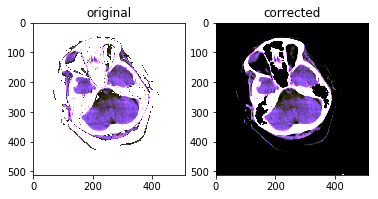

In [3]:
def window_with_correction(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_testing(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 30, 30)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - 15) / 30
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
dicom = pydicom.dcmread(train_images_dir + "ID_036db39b7" + ".dcm")

fig, ax = plt.subplots(1, 2)

ax[0].imshow(window_testing(dicom, window_without_correction), cmap=plt.cm.bone);
ax[0].set_title("original")
ax[1].imshow(window_testing(dicom, window_with_correction), cmap=plt.cm.bone);
ax[1].set_title("corrected");

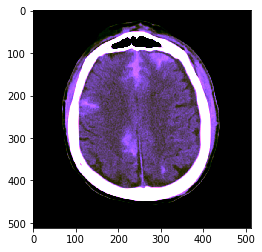

In [4]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

# Another sanity check 
plt.imshow(
    _read(train_images_dir+'ID_5c8b5d701'+'.dcm', (512, 512)), cmap=plt.cm.bone
);

In [5]:
# Image Augmentation
sometimes = lambda aug: iaa.Sometimes(0.25, aug)
augmentation = iaa.Sequential([ iaa.Fliplr(0.25),
                                iaa.Flipud(0.10),
                                sometimes(iaa.Crop(px=(0, 25), keep_size = True, sample_independently = False))   
                            ], random_order = True)      

class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 3), 
                 img_dir=train_images_dir, augment = True,*args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
    def augmentor(self, image):
        augment_img = augmentation        
        image_aug = augment_img.augment_image(image)
        return image_aug
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                image = _read(self.img_dir+ID+".dcm", self.img_size)
                if self.augment:
                    X[i,] = self.augmentor(image)
                else:
                    X[i,] = image
#                 X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

In [6]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):

    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):

    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):

    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):

    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [7]:
class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, test_df, valid_df, 
                 test_images_dir=test_images_dir, 
                 valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(512, 512, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose=2)[:len(self.test_df)])       


class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
        
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = keras.backend, layers = keras.layers,
                             models = keras.models, utils = keras.utils)
        
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
        x = keras.layers.Dropout(0.125)(x)
        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=engine.input, outputs=out)

        self.model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=[weighted_loss,'acc'])
    

    def fit_and_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        #checkpointer = keras.callbacks.ModelCheckpoint(filepath='%s-{epoch:02d}.hdf5' % self.engine.__name__, verbose=1, save_weights_only=True, save_best_only=False)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        self.model.fit_generator(
            DataGenerator(
                train_df.index, 
                train_df, 
                self.batch_size, 
                self.input_dims, 
                train_images_dir
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=False,
            workers=4,
            callbacks=[pred_history, scheduler]
        )
        
        return pred_history
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

In [16]:
# filename="E:/rsna-intracranial-hemorrhage-detection/stage_2_train.csv"
# df = pd.read_csv(filename)

# pd.concat(g for _, g in df.groupby("ID") if len(g) > 1)

,ID,Label
3705311,ID_489ae4179_any,0
3705317,ID_489ae4179_any,0
3705306,ID_489ae4179_epidural,0
3705312,ID_489ae4179_epidural,0
3705307,ID_489ae4179_intraparenchymal,0
3705313,ID_489ae4179_intraparenchymal,0
3705308,ID_489ae4179_intraventricular,0
3705314,ID_489ae4179_intraventricular,0
3705309,ID_489ae4179_subarachnoid,0
3705315,ID_489ae4179_subarachnoid,0


In [17]:
def read_testset(filename="E:/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename="E:/rsna-intracranial-hemorrhage-detection/stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        3705312, 3705313, 3705314, 3705315, 3705316, 3705317,
        1171830,  1171831,  1171832,  1171833,  1171834,  1171835,
        3842478, 3842479, 3842480, 3842481, 3842482, 3842483,
        56346, 56347, 56348, 56349, 56350, 56351
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

    
test_df = read_testset()
df = read_trainset()
print(df.head(20))

             Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
ID_0000aee4b     0        0                0                0            0   
ID_0000ca2f6     0        0                0                0            0   
ID_0000f1657     0        0                0                0            0   
ID_000178e76     0        0                0                0            0   
ID_00019828f     0        0                0                0   

In [18]:
print(df.shape)
print(test_df.shape)

(752803, 6)
(121232, 6)


In [19]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [20]:
def submission(history, i):
    test_df = read_testset()
    test_df.iloc[:, :] = np.average(history.test_predictions, axis=0, weights=[0, 0, 0, 2, 3, 7])
    test_df = test_df.stack().reset_index()
    test_df.insert(loc=0, column='ID', value=test_df['Image'].astype(str) + "_" + test_df['Diagnosis'])
    test_df = test_df.drop(["Image", "Diagnosis"], axis=1)
    test_df.to_csv('submission_fold_{}.csv'.format(i+1), index=False)

In [1]:
# train set (90%) and validation set (10%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# use cross-validation
for i in range(3):
    train_idx, valid_idx = next(ss)
#     print(train_idx[:5])
#     print(valid_idx[:5])

    # obtain model
    model = MyDeepModel(engine = efn.EfficientNetB2 , input_dims=(512, 512, 3), batch_size=8, learning_rate=5e-4,
                        num_epochs=6, decay_rate=0.8, decay_steps=1, weights="imagenet",verbose=1)
    # obtain test + validation predictions (history.test_predictions, history.valid_predictions)
    history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)
    submission(history, i)
#     model.save('C:/Users/physics/YunanWu/rsna challenge/code/weights_fold_{}.h5'.format(i+1))

In [23]:
len(history.test_predictions)

6

In [24]:
# get the results based on three-fold cross-validation result
file = [
    'submission_fold_1.csv',
    'submission_fold_2.csv',
    'submission_fold_3.csv',
]

out_dir = 'C:/Users/physics/YunanWu/rsna challenge'

os.makedirs(out_dir, exist_ok = True)
csv_file = out_dir + '/prediction.csv'

label = 0

for f in file:
    df = pd.read_csv(f)
    df = df.sort_values('ID')
    
    IDs = df['ID'].values
    label += df['Label'].values
    
label = label/len(file)
df = pd.DataFrame(list(zip(IDs, label)), columns = ['ID','Label'])
df.to_csv(csv_file, index = False)


In [26]:
sub = pd.read_csv('prediction.csv')
sub.Label = (sub.Label > 0.3).astype(float)
sub.to_csv('sub.csv', index = False)

In [ ]:
model.save('C:/Users/physics/YunanWu/rsna challenge/code/weights_test.h5')